In [1]:
import os
import sys
import argparse
import tensorflow as tf
import numpy as np

sys.path.append('libs')
from config import Config
import utils
import model as modellib
import visualize
from model import log
from edgelist_utils import refine_mask_with_edgelist
from SketchDataset import SketchDataset

Using TensorFlow backend.


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
from keras.backend.tensorflow_backend import set_session
tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True
set_session(tf.Session(config=tf_config))

In [3]:
class SketchInferConfig(Config):
    # Give the configuration a recognizable name
    NAME = "sketchyscene"

    # Train on 1 GPU and 16 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 16 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 46  # background + 46 classes

    # If enabled, resizes instance masks to a smaller size to reduce
    # memory load. Recommended when using high-resolution images.
    USE_MINI_MASK = True

    # image shape.
    IMAGE_MIN_DIM = 768
    IMAGE_MAX_DIM = 768

    # anchor side in pixels
    RPN_ANCHOR_SCALES = (32, 64, 128, 256, 512)

    # use the binary input to filter the pred_mask if 'True'
    IGNORE_BG = True

In [4]:
def segment_inference(arr):
    data_base_dir = arr['data_base_dir']
    dataset_type = arr['dataset_type']
    image_id = arr['image_id']
    epochs = arr['epochs']
    use_edgelist = arr['use_edgelist']

    outputs_base_dir = 'outputs'
    vis_result_save_dir = os.path.join(outputs_base_dir, 'visual_result', dataset_type)
    trained_model_dir = os.path.join(outputs_base_dir, 'snapshot')
    edgelist_result_dir = os.path.join(outputs_base_dir, 'edgelist')
    model_path = os.path.join(trained_model_dir, 'mask_rcnn_sketchyscene_' + epochs + '.h5')

    os.makedirs(vis_result_save_dir, exist_ok=True)

    config = SketchInferConfig()
    #config.display()

    # val/test dataset
    dataset_infer = SketchDataset(data_base_dir)
    dataset_infer.load_sketches(dataset_type)
    dataset_infer.prepare()

    # Recreate the model in inference mode
    model = modellib.MaskRCNN(mode="inference", config=config, model_dir='', log_dir='')

    # Load trained weights (fill in path to trained weights here)
    assert model_path != "", "Provide path to trained weights"
    #print("Loading weights from ", model_path)
    #model.load_weights(model_path, by_name=True)

    original_image, _, gt_class_id, gt_bbox, gt_mask, _ = \
        modellib.load_image_gt(dataset_infer, config, image_id - 1, use_mini_mask=False)

    log("original_image", original_image)
    log("gt_class_id", gt_class_id)
    log("gt_bbox", gt_bbox)
    log("gt_mask", gt_mask)
    
    print(gt_class_id.shape)
    print(gt_bbox.shape)
    print(gt_mask.shape)
    
    gt_seg_path = os.path.join(vis_result_save_dir, str(image_id) + '_gt.png')
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id,
                                dataset_infer.class_names, title='Ground-Truth',
                                save_path=gt_seg_path, fix_color=True)

    ## inference
    #results = model.detect([original_image], verbose=1)
    #r = results[0]

    #pred_boxes = r["rois"]  # (nRoIs, (y1, x1, y2, x2))
    #pred_class_ids = r["class_ids"]  # (nRoIs)
    #pred_scores = r["scores"]  # (nRoIs)
    #pred_masks = r["masks"]  # (768, 768, nRoIs)
    #log("pred_boxes", pred_boxes)
    #log("pred_masks", pred_masks)

    #if config.IGNORE_BG:
        # Use original_image(768, 768, 3) {0, 255} to filter pred_masks
        #pred_masks = np.transpose(pred_masks, (2, 0, 1))  # (nRoIs, 768, 768)
        #bin_input = original_image[:, :, 0] == 255
        #pred_masks[:, bin_input[:, :]] = 0  # (nRoIs, 768, 768)
        #pred_masks = np.transpose(pred_masks, (1, 2, 0))  # (768, 768, nRoIs)

    # refine pred_masks(768, 768, nRoIs) with edge-list
    #if use_edgelist:
        #refined_pred_masks = \
            #refine_mask_with_edgelist(image_id, dataset_type, data_base_dir, edgelist_result_dir,
                                      #pred_masks.copy(), pred_boxes)

    # caculating AP
    #iou_thresholds = np.linspace(.5, 0.95, np.round((0.95 - .5) / .05) + 1, endpoint=True)
    #APs = np.zeros([len(iou_thresholds)], dtype=np.float32)
    #APs_edg = np.zeros([len(iou_thresholds)], dtype=np.float32)
    #for i in range(len(iou_thresholds)):
        #iouThr = iou_thresholds[i]
        #AP, precisions, recalls, overlaps = \
            #utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                             #pred_boxes, pred_class_ids, pred_scores, pred_masks,
                             #iou_threshold=iouThr)
        #APs[i] = AP

        #if use_edgelist:
            #AP_edg, precisions, recalls, overlaps = \
                #utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                 #pred_boxes, pred_class_ids, pred_scores, refined_pred_masks,
                                 #iou_threshold=iouThr)
            #APs_edg[i] = AP_edg

    #mAP = np.mean(APs)
    #mAP_edg = np.mean(APs_edg)
    #print('APs', APs)
    #print('mAP', mAP)
    #print('APs_edg', APs_edg)
    #print('mAP_edg', mAP_edg)

    # save visual results
    #visual_seg_path = os.path.join(vis_result_save_dir, str(image_id) + '_seg.png')
    #visualize.display_instances(original_image, pred_boxes, pred_masks, pred_class_ids,
                                #dataset_infer.class_names, pred_scores, title='Normal result',
                                #save_path=visual_seg_path, fix_color=True)

    #if use_edgelist:
        #visual_seg_edg_path = os.path.join(vis_result_save_dir, str(image_id) + '_seg_edgelist.png')
        #visualize.display_instances(original_image, pred_boxes, refined_pred_masks, pred_class_ids,
                                    #dataset_infer.class_names, pred_scores, title='Result with edgelist',
                                    #save_path=visual_seg_edg_path, fix_color=True)

In [5]:
arr = {'data_base_dir': '../data','dataset_type': 'val','image_id': 2, 'epochs': '0100', 'use_edgelist': 0}






Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead

Instructions for updating:
Use `tf.cast` instead.

Instructions for updating:
Use `tf.cast` instead.
original_image           shape: (768, 768, 3)         min:    0.00000  max:  255.00000
gt_class_id              shape: (17,)                 min:   15.00000  max:   46.00000
gt_bbox                  shape: (17, 4)               min:   14.00000  max:  768.00000
gt_mask                  shape: (768, 768, 17)        min:    0.00000  max:    1.00000
(17,)
(17, 4)
(768, 768, 17)


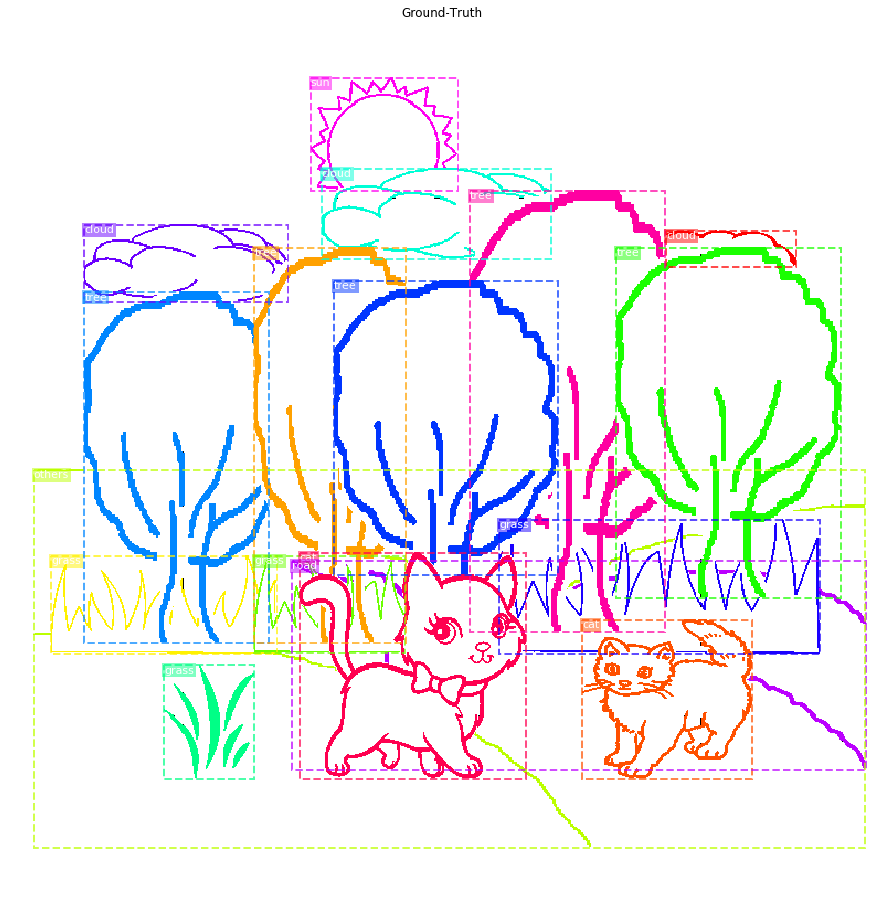

In [6]:
segment_inference(arr)

original_image           shape: (768, 768, 3)         min:    0.00000  max:  255.00000
gt_class_id              shape: (7,)                  min:   22.00000  max:   43.00000
gt_bbox                  shape: (7, 4)                min:    0.00000  max:  768.00000
gt_mask                  shape: (768, 768, 7)         min:    0.00000  max:    1.00000
(7,)
(7, 4)
(768, 768, 7)


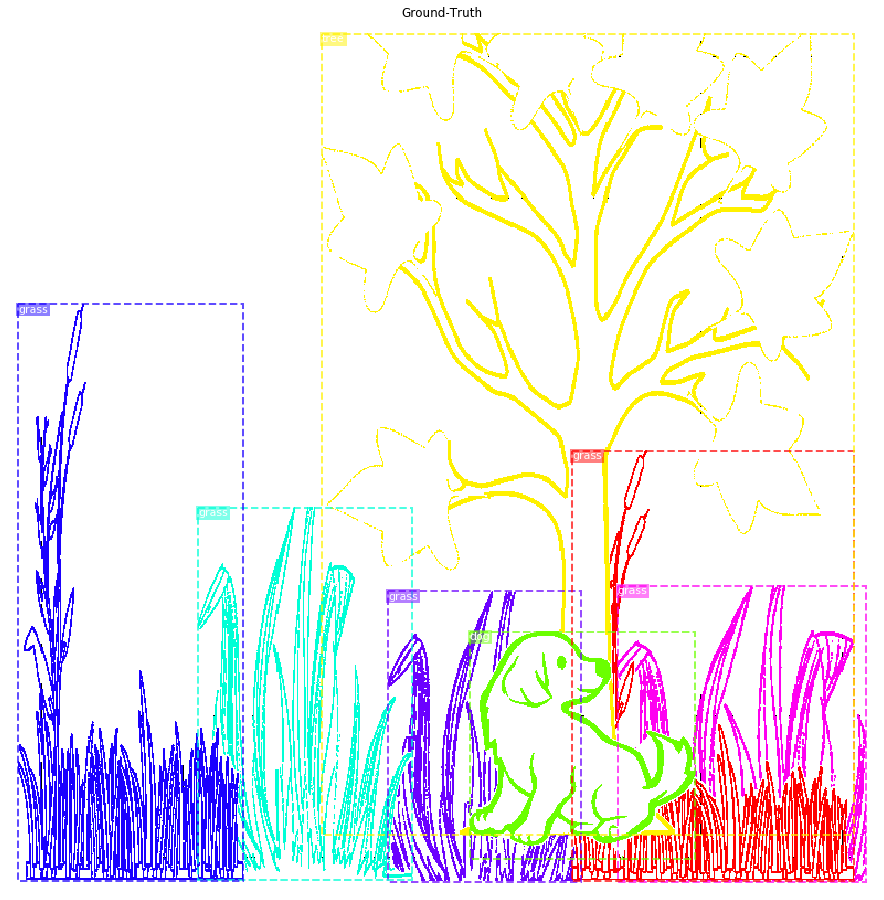

In [8]:
segment_inference({'data_base_dir': '../data','dataset_type': 'val','image_id': 4, 'epochs': '0100', 'use_edgelist': 0})

In [15]:
from tensorflow import keras
from keras.layers import Dense, Input
from keras.models import Model

In [11]:
input_size = 589824

model = keras.Sequential([
    keras.layers.Flatten(input_shape=(input_size, 768)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(input_size, activation='sigmoid')
])

model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 589824)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               75497600  
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               4224      
_________________________________________________________________
dense_3 (Dense)              (None, 768)               99072     
Total params: 75,605,024
Trainable params: 75,605,024
Non-trainable params: 0
__________________________________________________________

In [17]:
input_size = 589824
hidden_size = 128
code_size = 32

input_img = Input(shape=(input_size,))
hidden_1 = Dense(hidden_size, activation='relu')(input_img)
code = Dense(code_size, activation='relu')(hidden_1)
hidden_2 = Dense(hidden_size, activation='relu')(code)
output_img = Dense(input_size, activation='sigmoid')(hidden_2)

autoencoder = Model(input_img, output_img)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')


In [ ]:
autoencoder.fit(x_train, x_train, epochs=5)